In [1]:
import pandas as pd
import os
import numpy as np
import geopy
import geopandas
import matplotlib.pyplot as plt
import math
import re

# Residential Tree Planting project data prep

## Loading and formatting data

In [2]:
#Rename excel files
old_names = list(os.listdir('./data'))

for i in old_names:
    if '.xlsx' not in i or '$' in i:
        old_names.remove(i)

old_names

['boundaries',
 'fall_2023.xlsx',
 'fall_2024.xlsx',
 'fall_2025.xlsx',
 'spring_2023.xlsx',
 'spring_2024_1.xlsx',
 'spring_2024_2.xlsx',
 'spring_2025.xlsx']

In [3]:
new_names = []
for i in old_names:
    new_name = i.lower().replace(" ","_").strip()
    new_name = new_name.replace("casey_", "").replace("tree_","").replace("trees_","").replace("planting_","")
    new_names.append(new_name)

new_names

['boundaries',
 'fall_2023.xlsx',
 'fall_2024.xlsx',
 'fall_2025.xlsx',
 'spring_2023.xlsx',
 'spring_2024_1.xlsx',
 'spring_2024_2.xlsx',
 'spring_2025.xlsx']

In [4]:
# Read files into df
dfs = {}
for i in new_names:
    if 'xlsx' in i:
        dfs[i] = pd.read_excel(("./data/"+i), header=0)

C:\Users\pmedina\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [5]:
dfs.keys()

dict_keys(['fall_2023.xlsx', 'fall_2024.xlsx', 'fall_2025.xlsx', 'spring_2023.xlsx', 'spring_2024_1.xlsx', 'spring_2024_2.xlsx', 'spring_2025.xlsx'])

## Formatting data functions

### Column names cleaning

In [6]:
# Variable name formatting
def clean_column_names(df):
    df.columns = (df.columns
               .str.strip()
               .str.lower()
               .str.replace(" ", "_")
               .str.replace(";","")
               .str.replace("\\t","")
               .str.replace("[()€$]", "",

                            regex=True))
    return df

### Update species fields 

In [7]:
pd.set_option('mode.chained_assignment', None)
def update_species(df):
    species_columns = ['species_1', 'species_2', 'species_3', 'species_4']
    df_columns = list(df.columns)
    test_value = 0
    for name in species_columns:
        if name in df_columns:
            test_value += 1
    if test_value >= 3:
        return df
    else:
        for index, row in df.iterrows():
            if ',' in row['species_1']:
                species = df.loc[index, 'species_1'].split(',')
                species_1 = species[0]
                species_2 = species[1]
                df.loc[index, 'species_1'] = species_1
                df.loc[index, 'species_2'] = species_2
            elif '2' in row['species_1']:
                species = row['species_1'].strip().replace('2','').replace('()','')
                df.loc[index, 'species_1'] = species
                df.loc[index, 'species_2'] = species
            else:
                row['species_2'] = ''
        return df

In [8]:
def transform_species(df):
    # Create variables for the function
    new_df = df[["city_district", "address", "species_1", "year"]].copy() # New dataframe
    new_df.rename(columns={"species_1":"species"}, inplace=True) # Rename column species_1 to species
    initial_value = False # Set initial value
    extra_species = ["species_2", "species_3", "species_4"] # Extra species columns
    counter = 0
    
    # If the dataframe has any of the extra species columns set the initial value to True 
    for column in df.columns: 
        if "species" in column:
            counter += 1
    
    #df.drop("species_1", axis=1, inplace=True) # Drop species 1 since it's already included in the new df
    
    # If the initial value is True, then
    if counter > 1:
        for index, row in df.drop("species_1", axis=1,).iterrows(): # For each indexed row in the input dataframe
            for column in df.columns: # For each column in the input dataframe
                if column in extra_species: # If the column is in the extra species columns list
                    if (str(row[column]).lower() != "nan") and (len(str(row[column])) > 2): # If the row is not empty
                        # Create a new row with city district, address, species, and year as fields
                        new_row = pd.DataFrame({"city_district": [row["city_district"]], 
                                                "address": [row["address"]], 
                                                "species": [row[column]], 
                                                "year": [row["year"]]}) 
                        # Add the new row to the copied new dataframe
                        new_df = pd.concat([new_df, new_row], ignore_index=True)
        # Return the new dataframe
        return new_df
    else:
        new_df = df.rename(columns={"species_1": "species"})
        return new_df

### Drop variables containing PII and unnecesary ones

In [9]:
def column_clean(df):
    del_words = ['application', 'name','email','casey','form','contact','area','inspection','date','phone','quantity','insp']
    column_list = list(df.columns)
    columns_to_drop = []
    new_df = df

    if 'unnamed:_1' in column_list:
        new_column_names = list(new_df.loc[0,])
        new_df.columns = new_column_names
        new_df = clean_column_names(new_df)
        new_df = new_df.iloc[1:]
        column_list = list(new_df.columns)
        
    for column_name in column_list:
        for word in del_words:
            if word in column_name:
                if column_name not in columns_to_drop:
                    columns_to_drop.append(column_name)

    new_df.drop(columns=columns_to_drop, axis = 1, inplace = True)
     
    species_columns = 1
    
    for column_name in column_list:
        if "species" in column_name:
            # species_columns.append(column_name)
            new_name = 'species_' + str(species_columns)
            new_df.rename(columns={column_name:new_name}, inplace = True)
            species_columns += 1
        elif "district_#" in column_name or 'city_dist' in column_name:
            new_df.rename(columns={column_name:"city_district"}, inplace = True)
        elif "address" in column_name:
            new_df.rename(columns={column_name:"address"}, inplace = True)
        elif "district" in column_name:
            new_df.rename(columns={column_name:"city_district"}, inplace = True)
        
            
    return new_df
            

### Create main function

In [10]:
def format_table(df, year):
    if 'unnamed:_1' in list(df.columns):
            new_df = column_clean(df)
            new_df = update_species(new_df)
            new_df['year'] = year
            new_df = transform_species(new_df)
            return new_df
    else:
            new_df = clean_column_names(df)
            new_df = column_clean(new_df)
            new_df = update_species(new_df)
            new_df['year'] = year
            new_df = transform_species(new_df)
            return new_df

### Geolocate function

In [11]:
from geopy.geocoders import Nominatim
 
geolocator = Nominatim(user_agent="myapp")

def geocode(table, field):
    lat=[] #Latitude list
    lon=[] #Longitude list
    progress = 0 #Progress percentage
    total = len(table)
    #For each row
    for index, row in table.iterrows():
        #Geolocate passing the address field for the geolocator
        location = geolocator.geocode(row[field], timeout=None)
        if location is not None: #If the geolocator returns a valid value
            latitude = location.latitude #extract the latitude value
            longitude = location.longitude #Extract the longitude value
            lat.append(latitude) #Append it to the lat list
            lon.append(longitude) #Append it to the long list
        else: #If the function returns an invalid value
        #Set the values a 0,0
            lat.append(0)
            lon.append(0)
        progress += 1
        percentage = progress/total*100
        #print("%.2f %%" % percentage, end="\r", flush=True)
        print(" " * 50, end="\r", flush=True) # Clear the line
        print(f"{percentage:.2f} %", end="\r", flush=True)
    #Return the list
    return lat, lon

## Format tables

In [12]:
spring_2023 = dfs['spring_2023.xlsx']
fall_2023 = dfs['fall_2023.xlsx']
spring_2024_2 = dfs['spring_2024_2.xlsx']
fall_2025 = dfs['fall_2025.xlsx']
fall_2024 = dfs['fall_2024.xlsx']
spring_2025 = dfs['spring_2025.xlsx']
spring_2024_1 = dfs['spring_2024_1.xlsx']

### Spring 2023

In [13]:
spring_2023.head(2)

,Application Date; Planting on Resid Property,Area,District #,First and Last Name:,Email Address:,Phone Number:,Address:,Preferred Contact,Consultation date,Casey Trees date planted,City inspection date,Species planted,Notes (Casey Trees)
0,2022-05-14 21:50:25,Daniels Pk E,1,Kirstin Showalter,kirstinsd@gmail.com,7346492987,5121 Kenesaw St,Email,2023-02-28,NaN,NaN,"A.Hornbeam, Wil Oak",match
1,2022-11-11 13:10:39,Daniels Pk W,1,Anne Tolbert,ktolbertmd@gmail.com,301-613-3496,4908 Hollywood Rd,Email,2023-03-01,NaN,NaN,(2) Willow Oaks,no map


In [14]:
spring_2023 = format_table(spring_2023, 2023)

In [15]:
spring_2023

,city_district,address,species,year
0,1,5121 Kenesaw St,A.Hornbeam,2023
1,1,4908 Hollywood Rd,Willow Oaks,2023
2,1,4822 Erie Street,S. Magnolia,2023
3,1,5017 Laguna Road,S. Magnolia,2023
4,1,9118 Autoville Dr.,Am. Witch Hazel,2023
5,2,8302 49TH AVE,Baldcypress,2023
6,3,4614 Amherst Rd,Catalpa,2023
7,3,7207 Rhode Island Ave,Am. Hornbeam,2023
8,3,5911 Bryn Mawr Rd,S. Magnolia,2023
9,4,9116 Saint Andrews Pl,Am. Holly,2023


### Fall 2023

In [16]:
fall_2023.head(2)

,Casey Tree Planting on Private Property FALL 2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Application Date; Planting on Residential Prop...,Area,District #,First and Last Name:,Email Address:,Phone Number,Address:,Preferred Contact,Consultation date,Casey Trees date planted,City inspection date,Species planted,Hold Harmless Form completed
1,2022-06-25 00:00:00,CP Estates,3,Andrew Stephens,andrewstephens11@gmail.com,202-550-5392,7512 Wellesley Dr,email,2023-06-08 00:00:00,2024-10-30 00:00:00,2023-11-17 00:00:00,American Linden,X


In [17]:
fall_2023 = format_table(fall_2023, 2023)
#fall_2023 = fall_2023.drop(0)
fall_2023.head(5)

,city_district,address,species,year
1,3,7512 Wellesley Dr,American Linden,2023
2,4,3711 Marlbrough Way,Red Maple,2023
3,2,4803 Ruatan St,Tulip Poplar,2023
4,1,4806 Lackawanna St,Southern Magnolia,2023
5,1,9815 52nd Pl,Tulip Poplar,2023


### Spring 2024 - 1

In [18]:
spring_2024_1.head(2)

,Application Date; Planting on Residential Property,City District,First and Last Name:,Email Address:,Phone Number,Address:,Consultation date,Casey pl,City insp,Species planted,Hold Harmless Form completed
0,2023-09-17,1,Anning Cheng,anningc@yahoo.com,757-268-8522,5109 Iroquois St,2023-12-08,2024-04-05,2024-04-23,Red Maple,X
1,2023-10-08,1,Kim Tolbert,ktolbertmd@gmail.com,301-613-3496,4908 Hollywood Rd,2023-12-08,2024-04-05,2024-04-23,"Beech, Red Maple",X


In [19]:
spring_2024_1 = format_table(spring_2024_1, 2024)
spring_2024_1.head(5)

,city_district,address,species,year
0,1,5109 Iroquois St,Red Maple,2024
1,1,4908 Hollywood Rd,Beech,2024
2,1,4810 Lackawanna St,Dogwood,2024
3,1,5106 Lackawanna St,Southern Magnolia,2024
4,1,9735 53rd Ave,Red Maple,2024


### Spring 2024 - 2

In [20]:
spring_2024_2.head(2)

,Casey Tree Planting on Private Property SPRING 2024 (MAY),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Application Date; Planting on Residential Prop...,City District,First and Last Name:,Email Address:,Phone Number,Address:,Consultation date,Casey Trees date planted,City inspection date,Species planted,Hold Harmless Form completed
1,2024-02-28 00:00:00,1,Jeff Miller,jeffmillerworld@gmail.com,443-764-6083,9609 50th Place,2024-02-28 00:00:00,2024-04-10 00:00:00,2024-04-23 00:00:00,"Beech, Swamp White Oak",X


In [21]:
spring_2024_2 = format_table(spring_2024_2, 2024)
spring_2024_2.head(10)

,city_district,address,species,year
0,1,9609 50th Place,Beech,2024
1,1,9540 Rhode Island Ave,Persimmon,2024
2,1,5121 Kennebunk Terr,Freeman Maple,2024
3,2,4811 Ruatan St,Swamp White Oak,2024
4,3,7510 Wellesley Dr,Redbud,2024
5,3,4611 Drexel Rd,Persimmon,2024
6,4,3739 Marlbrough Way,Am. Holly,2024
7,4,7321 Radcliffe Dr,Am Holly,2024
8,NaN,NaN,Total = 14 trees,2024
9,1,9609 50th Place,Swamp White Oak,2024


### Fall 2024

In [22]:
fall_2024.head(2)

,City Dist,First and Last Name:,Email Address:,Phone Number:,Address of the Tree,Species 1,Species 2,Species 3,Species 4,Notes,Casey Trees date planted,City Inspetion date
0,1,William Crane,frunpro@outlook.com,2022465897,8611 Rhode Island Ave,American holly,Redbud,Swamp white oak,NaN,NaN,2024-11-19 00:00:00,2024-11-19 00:00:00
1,1,James Milmoe,milmoej2007@hotmail.com,4434667799,8709 48th Ave,American holly,Nuttall oak,NaN,NaN,NaN,2024-11-19 00:00:00,2024-11-19 00:00:00


In [23]:
fall_2024 = format_table(fall_2024, 2024)
fall_2024.head(5)

,city_district,address,species,year
0,1,8611 Rhode Island Ave,American holly,2024
1,1,8709 48th Ave,American holly,2024
2,1,9629 52nd Ave,Redbud,2024
3,1,6917 Carleton Ter,Apple serviceberry,2024
4,1,9621 Narragansett Pkwy,Persimmon,2024


### Spring 2025

In [24]:
spring_2025.head(2)

,City Dist,First and Last Name:,Email Address:,Phone Number:,Address of the Tree,Species 1,Species 2,Species 3,Species 4,Notes,Casey Trees date planted,City Inspetion date
0,1,Silvia Alvarado,marylicastillo@gmail.com,202-460-5615,9406 52nd Ave,Arborvitae,Arborvitae,NaN,NaN,NaN,NaN,NaN
1,1,Brian Mayers,soccerplaya37@gmail.com,443-534-4109,5202 Lackawanna St,Southern Magnolia,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
spring_2025 = format_table(spring_2025, 2025)
spring_2025.head(5)

,city_district,address,species,year
0,1,9406 52nd Ave,Arborvitae,2025
1,1,5202 Lackawanna St,Southern Magnolia,2025
2,1,9037 49th Pl,NS Holly,2025
3,1,4712 Nantucket Rd,Am Elm,2025
4,1,5022 Geronimo St,Redbud,2025


### Fall 2025

In [26]:
fall_2025.head(2)

,First and Last Name:,Email Address:,Phone Number:,District,Address,Species 1,Species 2,Tree quantity
0,Adam Claudy,atclaudy@gmail.com,301-356-0282,Disctrict 1,9400 49th Ave,Redbud,NaN,1
1,Aida Xhepa,aidaxhepa@gmail.com,202-445-4361,Disctrict 1,9605 52nd Ave,Red Maple,NaN,1


In [27]:
fall_2025 = format_table(fall_2025, 2025)
fall_2025.head()

,city_district,address,species,year
0,Disctrict 1,9400 49th Ave,Redbud,2025
1,Disctrict 1,9605 52nd Ave,Red Maple,2025
2,Disctrict 3,5012 Roanoke Pl,Apple Serviceberry,2025
3,Disctrict 2,8619 Rhode Island Ave,Ironwood (Hophornbeam),2025
4,Disctrict 1,9505 52nd Ave,Sweetbay Magnolia,2025


In [28]:
fall_2025

,city_district,address,species,year
0,Disctrict 1,9400 49th Ave,Redbud,2025
1,Disctrict 1,9605 52nd Ave,Red Maple,2025
2,Disctrict 3,5012 Roanoke Pl,Apple Serviceberry,2025
3,Disctrict 2,8619 Rhode Island Ave,Ironwood (Hophornbeam),2025
4,Disctrict 1,9505 52nd Ave,Sweetbay Magnolia,2025
...,...,...,...,...
56,Disctrict 3,7307 Baylor Ave,Overcup Oak,2025
57,Disctrict 2,8700 49th Ave,Holly,2025
58,Disctrict 3,7400 Dartmouth Ave,American Hornbeam,2025
59,Disctrict 1,9727 53rd Ave,Brackens,2025


### Consolidate data

In [29]:
consolidated_data = pd.concat([spring_2023,fall_2023,spring_2024_1,spring_2024_2,fall_2024,spring_2025,fall_2025])

In [30]:
consolidated_data['address'] = consolidated_data['address'] + ", College Park MD"

In [31]:
consolidated_data = consolidated_data.reset_index() #Reset index
del consolidated_data['index'] #Drop old index

In [32]:
for index, row in consolidated_data.iterrows():
    if 'Total' in row["species"]:
       consolidated_data.drop(index)

In [33]:
consolidated_data.head()

,city_district,address,species,year
0,1,"5121 Kenesaw St, College Park MD",A.Hornbeam,2023
1,1,"4908 Hollywood Rd, College Park MD",Willow Oaks,2023
2,1,"4822 Erie Street, College Park MD",S. Magnolia,2023
3,1,"5017 Laguna Road, College Park MD",S. Magnolia,2023
4,1,"9118 Autoville Dr. , College Park MD",Am. Witch Hazel,2023


### Consolidate species names

In [34]:
species_names = list(consolidated_data['species'].unique())

In [35]:
consolidated_data.index[consolidated_data['species']=='2 Southern Magnolia']

Index([80], dtype='int64')

Correct names with numbers

In [36]:
consolidated_data.loc[80,]

city_district                                         2
address          8323 Rhode Island Ave, College Park MD
species                             2 Southern Magnolia
year                                               2024
Name: 80, dtype: object

In [37]:
consolidated_data.at[80,'species'] = 'Southern Magnolia'

In [38]:
consolidated_data.index[consolidated_data['species']=='TBD']

Index([184, 225, 226, 227], dtype='int64')

In [39]:
consolidated_data.at[184,'species'] = 'Eastern Red Cedar'
consolidated_data.at[225,'species'] = 'Eastern Red Cedar'
consolidated_data.at[226,'species'] = 'Eastern Red Cedar'
consolidated_data.at[227,'species'] = 'Eastern Red Cedar'

### Reaload the unique species values

In [40]:
species_names = []

In [41]:
species_fields = []
species_fields.append(list(consolidated_data['species'].unique()))

In [42]:
for list_item in species_fields:
    for item in list_item:
        species_names.append(item)

### Create dictionary for the new species name

In [43]:
species_names_keys = {}

for name in species_names:
    new_name = ''
    if 'A.' in str(name):
        new_name = name.replace('A.','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Am.' in str(name):
        new_name = name.replace('Am.','American').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Amer ' in str(name):
        new_name = name.replace('Amer ','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Americanholly' in str(name):
        new_name = 'American Holly'
        species_names_keys[name] = new_name.title()
    elif 'Am ' in str(name):
        new_name = name.replace('Am ','American ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'S.' in str(name):
        new_name = name.replace('S.','Southern').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif ' Wil ' in str(name):
        new_name = name.replace(' Wil ','Willow ').lstrip(' ')
        species_names_keys[name] = new_name.title()
    elif 'Oaks' in str(name):
        new_name = name.replace('Oaks','Oak').lstrip(' ')
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif ' Magnol' in str(name):
        new_name = re.sub('Magnol$', 'Magnolia', name)
        species_names_keys[name] = new_name.title()
    elif 'Baldcypress' in str(name):
        new_name = re.sub('Baldcypress$', 'Bald Cypress', name)
        species_names_keys[name] = new_name.title()
    elif 'Honeylocust' in str(name):
        new_name = re.sub('Honeylocust$', 'Honey locust', name)
        species_names_keys[name] = new_name.title()
    elif ' Eastern Redcedar' in str(name):
        new_name = 'Eastern Red cedar'
        species_names_keys[name] = new_name.title()
    elif ' Freemen Maple' in str(name):
        new_name = 'Freeman Maple'
        species_names_keys[name] = new_name.title().lstrip(' ')
    elif '2 Prince Oak' in str(name):
        new_name = 'Pin Oak'
        species_names_keys[name] = new_name.title().lstrip(' ')
    else:
        new_name = str(name).strip()
        species_names_keys[name] = new_name.title().lstrip(' ')
        

### Update values

In [44]:
for index, row in consolidated_data.iterrows():
    if row["species"] in list(species_names_keys.keys()):
        consolidated_data.at[index, "species"] = str(species_names_keys[row["species"]])

In [45]:
consolidated_data.head()

,city_district,address,species,year
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023


 # Merge Values to calcualte carbon storage

# Calculate Variables
Will calcualte the following:
* Carbon sequestration
* Rainfall interception
* Energy stored

## Growth and wood type

In [46]:
tree_growth = "./Tree_data_tables.xlsx"
tree_growth = pd.read_excel(tree_growth, sheet_name = "Growth_type")
tree_growth.head()

,Common name,Species,Type,Growth
0,Ailanthus,"Ailanthus, Ailanthus altissima",H,F
1,European Alder,"Alder, European, Alnus glutinosa",H,F
2,Green Ash,"Ash, green, Fraxinus pennsylvanica",H,F
3,American Mountain Ash,"Ash, mountain, American,Sorbus americana",H,M
4,White Ash,"Ash, white, Fraxinus americana",H,F


In [47]:
merged = pd.merge(consolidated_data, tree_growth[["Common name","Type","Growth"]], left_on = "species", right_on = "Common name", how = "left") 
merged.head()

,city_district,address,species,year,Common name,Type,Growth
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,NaN,NaN
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,NaN,NaN


In [48]:
merged["Type"] = merged["Type"].astype(str)

In [49]:
merged["Type"] = merged["Type"].map(lambda x: "H" if x == 'nan' else x)

In [50]:
merged["Growth"] = merged["Growth"].astype(str)

In [51]:
merged["Growth"] = merged["Growth"].map(lambda x: "M" if x == 'nan' else x)

In [52]:
merged.head()

,city_district,address,species,year,Common name,Type,Growth
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M


## Survival Factor

In [53]:
tree_survival = "./Tree_data_tables.xlsx"
tree_survival = pd.read_excel(tree_survival, sheet_name = "Survival_factor")
tree_survival.head()

,Years,Slow,Moderate,Fast
0,0,0.873,0.873,0.873
1,1,0.798,0.798,0.798
2,2,0.736,0.736,0.736
3,3,0.706,0.706,0.706
4,4,0.678,0.678,0.678


### Calculate tree age

In [54]:
# Get the tree age
merged["age"] = merged["year"].map(lambda x: 2025 - x)
merged.head()

,city_district,address,species,year,Common name,Type,Growth,age
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2


In [55]:
merged["survival"] = merged.apply(lambda row: tree_survival.loc[row["age"], "Moderate"] 
                         if row["Growth"] == "M" 
                         else (tree_survival.loc[row["age"], "Fast"] 
                               if row["Growth"] == "F" 
                               else tree_survival.loc[row["age"], "Slow"]), 
                         axis=1)

In [56]:
merged.head()

,city_district,address,species,year,Common name,Type,Growth,age,survival
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2,0.736
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2,0.736
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2,0.736


## Anual carbon sequestration

In [57]:
hardwood_seq = "./Tree_data_tables.xlsx"
hardwood_seq = pd.read_excel(hardwood_seq, sheet_name = "Annual_sequestration_hardwood")
hardwood_seq.head()

,Years,Slow,Moderate,Fast
0,0,1.3,1.9,2.7
1,1,1.6,2.7,4.0
2,2,2.0,3.5,5.4
3,3,2.4,4.3,6.9
4,4,2.8,5.2,8.5


In [58]:
conifer_seq = "./Tree_data_tables.xlsx"
conifer_seq = pd.read_excel(conifer_seq, sheet_name = "Annual_sequestration_conifer")
conifer_seq.head()

,Years,Slow,Moderate,Fast
0,0,0.7,1.0,1.4
1,1,0.9,1.5,2.2
2,2,1.1,2.0,3.1
3,3,1.4,2.5,4.1
4,4,1.6,3.1,5.2


In [59]:
def getSequestration(wood_type, growth, age):
    growth_dict = {"S": "Slow", "M": "Moderate", "F":"Fast"}
    if wood_type == "H":
        seq_value = hardwood_seq.loc[age,growth_dict[growth]]
    else:
        seq_value = conifer_seq.loc[age,growth_dict[growth]]
    return seq_value

In [60]:
# Create field for carbon sequestration
merged["carbon_seq"] = 0.0

In [61]:
for index, row in merged[["Type","Growth","age","carbon_seq"]].iterrows():
    merged.iloc[index, 9] = getSequestration(row.iloc[0], row.iloc[1], row.iloc[2])
merged.head()

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2,0.736,3.5
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2,0.736,3.5
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,3.5
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,3.5
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2,0.736,3.5


In [62]:
# Carbon Pounds

merged["carbon_seq"] = merged["carbon_seq"].map(lambda x: x * 3.67)
consolidated_data = merged
consolidated_data.head()

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2,0.736,12.845
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2,0.736,12.845
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2,0.736,12.845


In [63]:
consolidated_data

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2,0.736,12.845
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2,0.736,12.845
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2,0.736,12.845
...,...,...,...,...,...,...,...,...,...,...
338,Disctrict 3,"7307 Baylor Ave, College Park MD",Overcup Oak,2025,Overcup Oak,H,S,0,0.873,4.771
339,Disctrict 2,"8700 49th Ave, College Park MD",Holly,2025,NaN,H,M,0,0.873,6.973
340,Disctrict 3,"7400 Dartmouth Ave, College Park MD",American Hornbeam,2025,NaN,H,M,0,0.873,6.973
341,Disctrict 1,"9727 53rd Ave, College Park MD",Brackens,2025,NaN,H,M,0,0.873,6.973


## Geocode data

In [64]:
coordinates = geocode(consolidated_data, 'address')

consolidated_data["lat"] = coordinates[0]
consolidated_data["lon"] = coordinates[1]

### Check outliers

In [65]:
#Load consolidated dataset as geopandas object
gdf = geopandas.GeoDataFrame(
    consolidated_data, geometry=geopandas.points_from_xy(consolidated_data.lon, consolidated_data.lat), crs="EPSG:4326"
)

In [66]:
cp = geopandas.read_file("data/boundaries/College_Park_City_Limits.shp")
cp = cp.to_crs(4326)
cp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

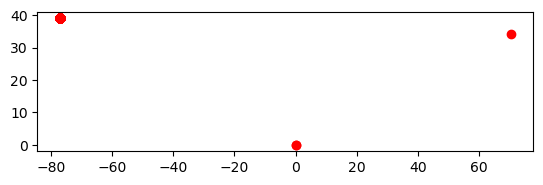

In [67]:
ax = cp.plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

Since some data seem to be out of the range, let's look at the coordinates sorted in descending order.

In [68]:
consolidated_data.sort_values(by='lon', ascending=False).head(5)

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
126,NaN,NaN,Total = 14 Trees,2024,NaN,H,M,1,0.798,9.909,34.220389,70.380031
178,3,"9224 Saint Andrew’s Pl, College Park MD",Tulip Tree,2024,NaN,H,M,1,0.798,9.909,0.000000,0.000000
59,4,"3504 DePauw Place, College Park MD",American Holly,2023,American Holly,H,S,2,0.736,7.340,0.000000,0.000000
226,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
225,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614


### Clean coordinates

#### Check the missing lat/lon

In [69]:
depaw_index = consolidated_data.index[consolidated_data['lat'] == 0].tolist()

##### De Pauw Place

In [70]:
depauw_pl_3504 =  geolocator.geocode('3504 De Pauw Place, College Park MD', timeout=None)
depauw_pl_3504

Location(3504, De Pauw Place, Crystal Springs, College Park Woods, College Park, Prince George's County, Maryland, 20740, United States, (39.0065389, -76.9465289, 0.0))

In [71]:
depauw_pl_3504.latitude

39.0065389

In [72]:
depaw_lat = depauw_pl_3504.latitude
depaw_lon = depauw_pl_3504.longitude

In [73]:
consolidated_data.loc[depaw_index, 'lat'] = depaw_lat
consolidated_data.loc[depaw_index, 'lon'] = depaw_lon

In [74]:
consolidated_data.sort_values(by='lon', ascending=False).head(5)

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
126,NaN,NaN,Total = 14 Trees,2024,NaN,H,M,1,0.798,9.909,34.220389,70.380031
226,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
225,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
184,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614
227,3,"7520 Edmonston Rd, College Park MD",Eastern Red Cedar,2024,Eastern Red Cedar,C,M,1,0.798,5.505,38.983182,-76.910614


In [75]:
# Drop total row
total_index = consolidated_data.index[consolidated_data['lon'] > 1 ].tolist()

consolidated_data = consolidated_data.drop([total_index[0]])

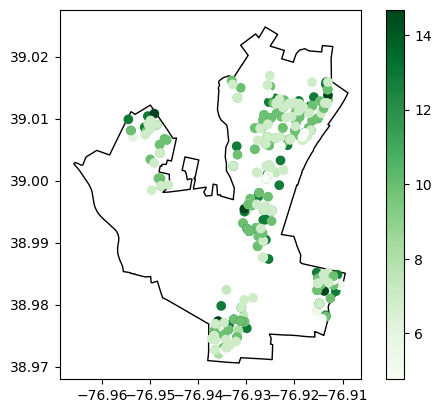

In [76]:
gdf = geopandas.GeoDataFrame(
    consolidated_data, geometry=geopandas.points_from_xy(consolidated_data.lon, consolidated_data.lat), crs="EPSG:4326"
)
ax = cp.plot(color="white", edgecolor="black")
# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='carbon_seq', cmap='Greens', legend=True)

plt.show()

In [77]:
saint_andrews_pl = geopandas.tools.geocode('9224 Saint Andrews Pl, College Park MD')
saint_andrews_pl

,geometry,address
0,POINT (-76.9498 39.0077),"9224, Saint Andrews Place, 20740, Saint Andrew..."


In [78]:
saint_andrews_pl_lat = saint_andrews_pl.centroid.y
saint_andrews_pl_lon = saint_andrews_pl.centroid.x
print("Latitude: %.4f \nLongitude: %.4f" % (saint_andrews_pl_lat, saint_andrews_pl_lon))

Latitude: 39.0077 
Longitude: -76.9498


C:\Users\pmedina\AppData\Local\Temp\ipykernel_5648\3482197277.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  saint_andrews_pl_lat = saint_andrews_pl.centroid.y
C:\Users\pmedina\AppData\Local\Temp\ipykernel_5648\3482197277.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  saint_andrews_pl_lon = saint_andrews_pl.centroid.x
C:\Users\pmedina\AppData\Local\Temp\ipykernel_5648\3482197277.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Latitude: %.4f \nLongitude: %.4f" % (saint_andrews_pl_lat, saint_andrews_pl_lon))


In [79]:
consolidated_data.at[154, 'lat'] = saint_andrews_pl_lat
consolidated_data.at[154, 'lon'] = saint_andrews_pl_lon

C:\Users\pmedina\AppData\Local\Temp\ipykernel_5648\2969598813.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  consolidated_data.at[154, 'lat'] = saint_andrews_pl_lat
C:\Users\pmedina\AppData\Local\Temp\ipykernel_5648\2969598813.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  consolidated_data.at[154, 'lon'] = saint_andrews_pl_lon


In [80]:
consolidated_data.head()

,city_district,address,species,year,Common name,Type,Growth,age,survival,carbon_seq,lat,lon
0,1,"5121 Kenesaw St, College Park MD",American Hornbeam,2023,NaN,H,M,2,0.736,12.845,39.007688,-76.917934
1,1,"4908 Hollywood Rd, College Park MD",Willow Oak,2023,Willow Oak,H,M,2,0.736,12.845,39.010871,-76.923609
2,1,"4822 Erie Street, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845,39.005966,-76.925937
3,1,"5017 Laguna Road, College Park MD",Southern Magnolia,2023,Southern Magnolia,H,M,2,0.736,12.845,39.012205,-76.919981
4,1,"9118 Autoville Dr. , College Park MD",American Witch Hazel,2023,NaN,H,M,2,0.736,12.845,39.005542,-76.931999


In [81]:
gdf = geopandas.GeoDataFrame(
    consolidated_data, geometry=geopandas.points_from_xy(consolidated_data.lon, consolidated_data.lat), crs="EPSG:4326"
)

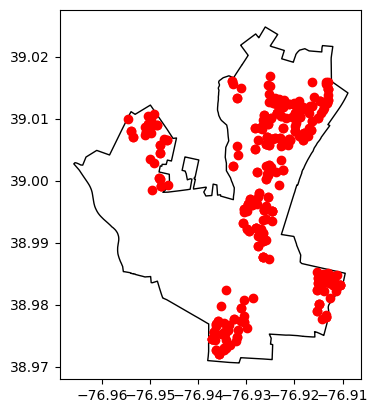

In [82]:
ax = cp.plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

# Save consolidated data

In [83]:
consolidated_data.to_csv('consolidated_data.csv')